In [1]:
import glob
import shutil 
from netCDF4 import Dataset
import numpy as np
import os
import yaml 

from obspy.core import Stream, Trace, UTCDateTime, Stats
from obspy.core.event import read_events
import matplotlib.pyplot as plt

lat  40.0 lon  0.0 depth  0.0
5.4465677932461336e-11
lat  45.0 lon  0.0 depth  0.0
2.4804854991574725e-11
lat  50.0 lon  0.0 depth  0.0
4.833781308205889e-11
lat  55.0 lon  0.0 depth  0.0
9.649774196640333e-11
lat  60.0 lon  0.0 depth  0.0
1.3798136854140324e-10
lat  65.0 lon  0.0 depth  0.0
2.5446765304459704e-10
lat  70.0 lon  0.0 depth  0.0
3.2971141708868894e-10
lat  75.0 lon  0.0 depth  0.0
4.544118173685216e-10
lat  80.0 lon  0.0 depth  0.0
7.523930253572134e-10
lat  85.0 lon  0.0 depth  0.0
1.0066693962193317e-09
lat  90.0 lon  0.0 depth  0.0
1.016585701704614e-09
lat  5.0 lon  0.0 depth  0.0
9.34152923961689e-12
lat  10.0 lon  0.0 depth  0.0
1.9065794385126695e-11
lat  15.0 lon  0.0 depth  0.0
2.599050476837018e-11
lat  20.0 lon  0.0 depth  0.0
6.313720606273096e-11
lat  30.0 lon  0.0 depth  0.0
1.5120490919183967e-10
lat  35.0 lon  0.0 depth  0.0
1.100137020332964e-10
lat  25.0 lon  0.0 depth  0.0
1.2021892597451533e-10
lat  -20.0 lon  0.0 depth  0.0
1.2918832865678165e-10
lat

Text(0.5, 0, 'Time [s]')

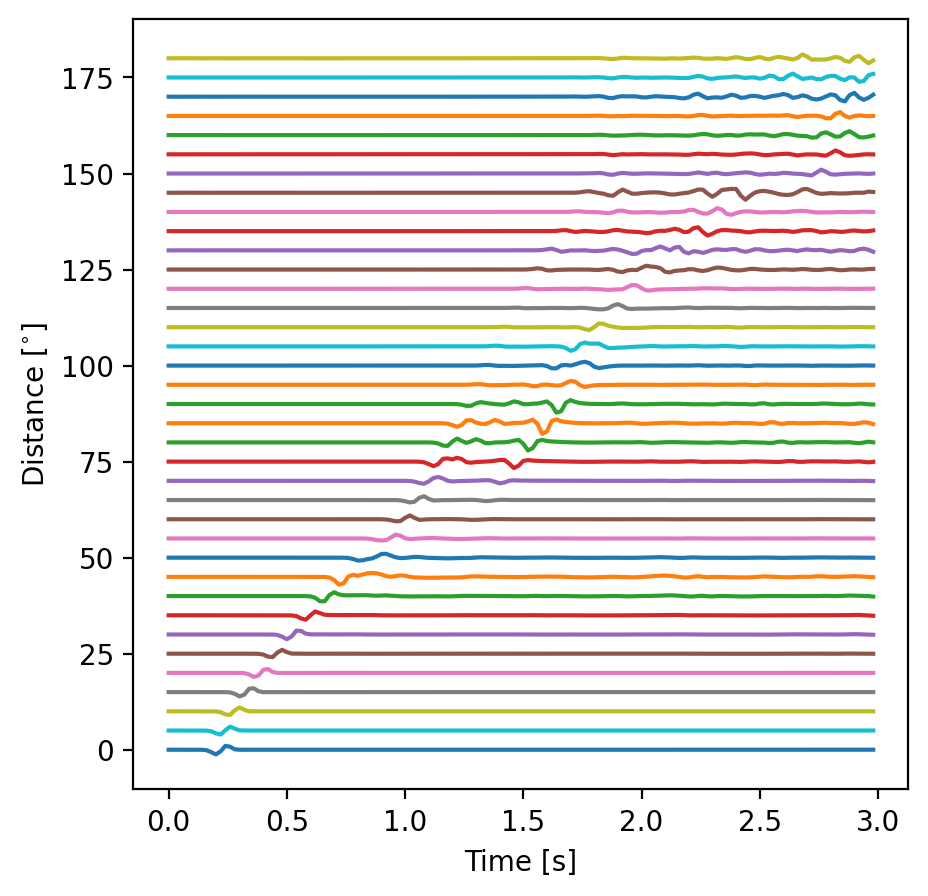

In [4]:
# Fig Preparation
dpi = 200
fig = plt.figure(figsize=(5,5),dpi=200)
ax = fig.add_subplot(111)


ModelName = 'SphericalHarmonicsAcousticBall0001'

# wave dimension to animation
output_channel = 'spz'
wave_dim_s = output_channel.index('s')
wave_dim_p = output_channel.index('p')
wave_dim_z = output_channel.index('z')
# wave_dim_X = output_channel.index('X')
BallRadius = 1000

displacement_or_potential = 'displacement'

RunPath = '../Runs/%s' %ModelName

StationInfo = np.loadtxt(RunPath+'/input/Synthetic_Stations_Ball.txt',dtype=str, skiprows=3)
stalatlon_dict = {}

for AppliedNetwork in ['SYN']:
    for item in StationInfo:
        # filter out unnecessary newwork
        if item[1] != AppliedNetwork:
            continue
        stkey = item[1]+'.'+item[0]
        x = float(item[2])
        y = float(item[3])
        depth = float(item[5])
        if stkey not in stalatlon_dict.keys():
            stalatlon_dict[stkey] = []
        stalatlon_dict[stkey].append((x, y, depth))


    StartTime, EndTime = 0, 3.0    # note in Second
    resample_rate = 0.02    # note in Second
    lowpass_freq = 20    # note in Hz

    PointPerTrace = int((EndTime - StartTime)/resample_rate)


    GSNDir = RunPath + '/output/stations/Synthetic_Stations'

    # read rank-station info
    rank_station_info = np.loadtxt(GSNDir + '/rank_station.info', dtype=str, skiprows=1)

    # dict: mpi-rank -> [station keys]
    rank_station_dict = {}
    for item in rank_station_info:
        rank = item[0]
        stkey = item[1]
        inrank_index = item[2]
        # initialize with an empty array if rank does not exists in rank_station_dict
        if rank not in rank_station_dict.keys():
            rank_station_dict[rank] = []
        # append the station
        rank_station_dict[rank].append([stkey, inrank_index])

    # loop over mpi-ranks to read data
    for rank in rank_station_dict.keys():
        f = Dataset(GSNDir + '/axisem3d_synthetics.nc.rank%s' %rank, 'r')
        time = f.variables['data_time'][:]

        for [StationName, inrank_index] in rank_station_dict[rank]:

            # if not StationName.startswith(AppliedNetwork):
            #     continue

            lat, lon = stalatlon_dict[StationName][0][0], stalatlon_dict[StationName][0][1]
            colat = 90 - lat

            if lon != 0:
                continue

            theta = np.radians(colat)
            phi = np.radians(lon)

            stadepth = stalatlon_dict[StationName][0][2]

            print('lat ', lat, 'lon ', lon, 'depth ', stadepth)

            # trace header
            stats = Stats()
            stats.starttime = UTCDateTime(time[0])
            stats.delta = UTCDateTime(time[1] - time[0])
            stats.npts = len(time)

            # stream
            stream = Stream()
            for ich, ch in enumerate(output_channel):
                stats.channel = ch  
                # default unit is km
                stream.append(Trace(f.variables['data_wave'][int(inrank_index)][ich], header=stats))

            stream.filter('lowpass', freq=lowpass_freq)
            stream.resample(1/resample_rate)
            # stream = stream.slice(UTCDateTime(int(arrivals[0].time)+StartTime), UTCDateTime(int(arrivals[0].time)+EndTime))
            stream = stream.slice(UTCDateTime(StartTime), UTCDateTime(EndTime))

            plot_trace = stream.select(component='z')[0]

            plt.plot(plot_trace.times(), plot_trace.data/plot_trace.data.max() + colat)
            print(plot_trace.data.max())

plt.ylabel('Distance [$^{\circ}$]')
plt.xlabel('Time [s]')

            

In [9]:
stream

3 Trace(s) in Stream:
...s | 1969-12-31T23:59:59.994967Z - 1970-01-01T00:00:02.974967Z | 50.0 Hz, 150 samples
...p | 1969-12-31T23:59:59.994967Z - 1970-01-01T00:00:02.974967Z | 50.0 Hz, 150 samples
...z | 1969-12-31T23:59:59.994967Z - 1970-01-01T00:00:02.974967Z | 50.0 Hz, 150 samples

In [11]:
plot_trace = stream.select(component='z')[0]

In [8]:
plot_trace.times()

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18,
       2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 ,
       2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 , 2.62,
       2.64, 2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82, 2.84,
       2.86, 2.88, 2.9 , 2.92, 2.94, 2.96, 2.98])

In [5]:
plot_trace.data

array([-1.08343595e-13,  9.57582444e-14, -8.57985850e-14,  7.79624944e-14,
       -7.12943694e-14,  6.58648839e-14, -6.10011656e-14,  5.69676881e-14,
       -5.32088141e-14,  5.00619360e-14, -4.70329157e-14,  4.44870828e-14,
       -4.19672776e-14,  3.98496026e-14, -3.76997544e-14,  3.58992907e-14,
       -3.40265189e-14,  3.24687798e-14, -3.08082779e-14,  2.94414495e-14,
       -2.79462333e-14,  2.67332614e-14, -2.53680927e-14,  2.42819212e-14,
       -2.30195278e-14,  2.20401233e-14, -2.08587440e-14,  1.99711832e-14,
       -1.88529069e-14,  1.80461224e-14, -1.69757159e-14,  1.62416705e-14,
       -1.52057124e-14,  1.45388639e-14, -1.35250677e-14,  1.29220437e-14,
       -1.19186916e-14,  1.13781276e-14, -1.03735581e-14,  9.89607674e-15,
       -8.87817817e-15,  8.46650313e-15, -7.42216869e-15,  7.08138647e-15,
       -5.99588106e-15,  5.73387832e-15, -4.59005630e-15,  4.41818498e-15,
       -3.19547640e-15,  3.12952981e-15, -1.80257663e-15,  1.86420741e-15,
       -4.00972766e-16,  